# Descrição do problema
O arquivo `desafio_fraude.csv` contém dados de crédito e o objetivo do case é prever fraudes de transações de cada caso.

O notebook foi dividido em:
* `EDA (Exploratory Data Analysis)`: Análise descritiva da base de dados
* `Dataprep`: Preparação da base para modelagem
* `Dataviz (redução de dimensionalidade)`: Redução de dimensionalidade para melhor visualização e discriminação dos casos de fraude
* `Modelling`: Modelagem do dataset para prever fraudes
* `Conclusion`: Conclusão das análises dos modelos

### Importings
Importando libs que usarei ao longo do notebook

In [424]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest, AdaBoostClassifier
from sklearn.svm import OneClassSVM, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from umap import UMAP
from time import time
import itertools
%matplotlib inline

In [2]:
df = pd.read_csv('desafio_fraude.csv')

### EDA (Exploratory Data Analysis)
Análise descritiva da base de dados

In [4]:
df.shape

(150000, 31)

Veremos se o dataset contém valores nulos

In [7]:
df.isnull().sum().any()

False

Checarei a proporção de casos de fraudes

In [161]:
df['Fraude'].value_counts(normalize=True)

0    0.99842
1    0.00158
Name: Fraude, dtype: float64

O dataset é bastante desbalanceado, com apenas `0,0158%` de fraudes na base.
Verei abaixo a distribuição dos valores de cada coluna

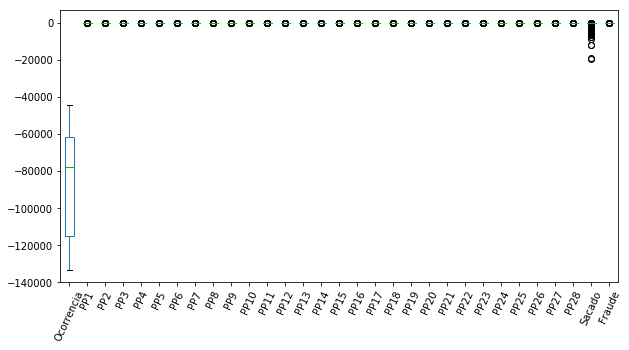

In [41]:
df.boxplot(rot=65, grid=False, figsize=(10, 5))
plt.show()

As colunas `Ocorrencia` e `Sacado` tem variâncias maiores que as demais colunas. Por ora, eliminarei-as para olhar com mais detalhes as demais colunas

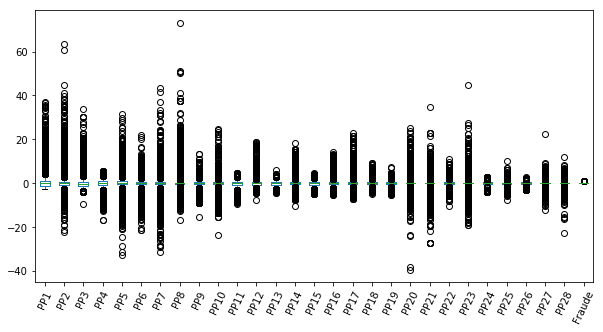

In [44]:
df.drop(['Ocorrencia', 'Sacado'], axis=1).boxplot(rot=65, grid=False, figsize=(10, 5))
plt.show()

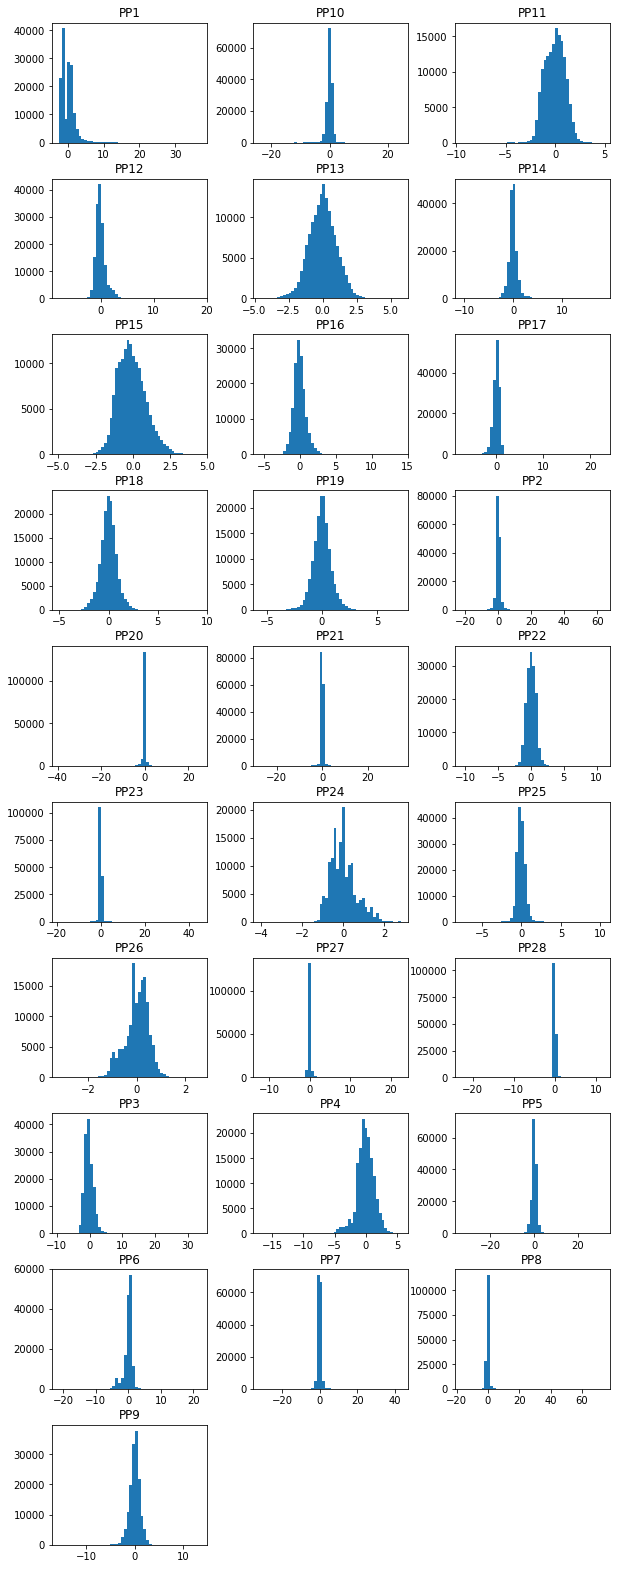

In [61]:
df.drop(['Ocorrencia', 'Sacado', 'Fraude'], axis=1).hist(bins=50, figsize=(10, 28), layout=(10, 3), grid=False)
plt.show()

Podemos notar que maioria dos valores estão concentrados próximos à `0`, tendo sido, provavelmente, padronizadas para esse problema

Abaixo checarei as distribuições das colunas `Fraude`, `Ocorrencia` e `Sacado`

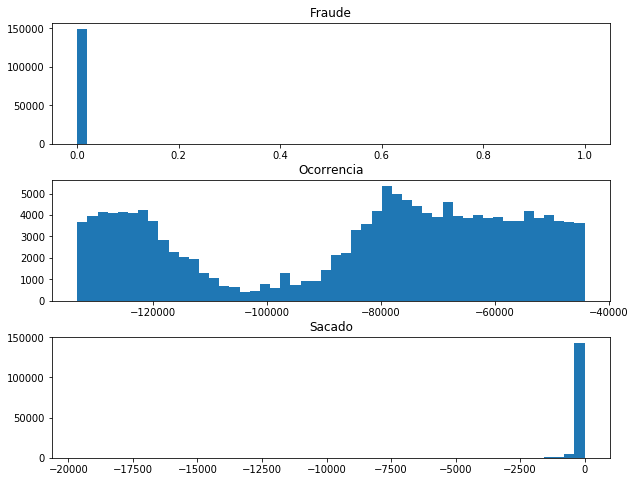

In [50]:
df.loc[:, ['Ocorrencia', 'Sacado', 'Fraude']].hist(bins=50, grid=False, figsize=(10, 8), layout=(3, 1))
plt.show()

Para deixar os dados de treino em escalas similares, padronizarei as colunas `Ocorrencia` e `Sacado` conforme abaixo

In [61]:
df['sc_ocorre'] = StandardScaler().fit_transform(df[['Ocorrencia']])
df['sc_sacado'] = StandardScaler().fit_transform(df[['Sacado']])

df.drop(['Ocorrencia', 'Sacado'], axis=1, inplace=True)

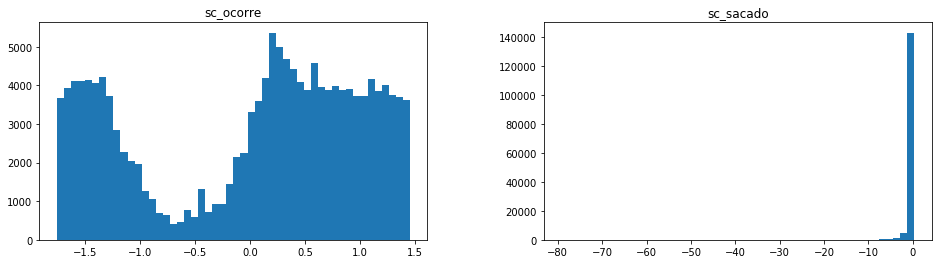

In [66]:
df.loc[:, ['sc_ocorre', 'sc_sacado']].hist(bins=50, grid=False, figsize=(16, 4), layout=(1, 2))
plt.show()

Podemos analisar se as colunas possuem correlação linear entre si conforme abaixo

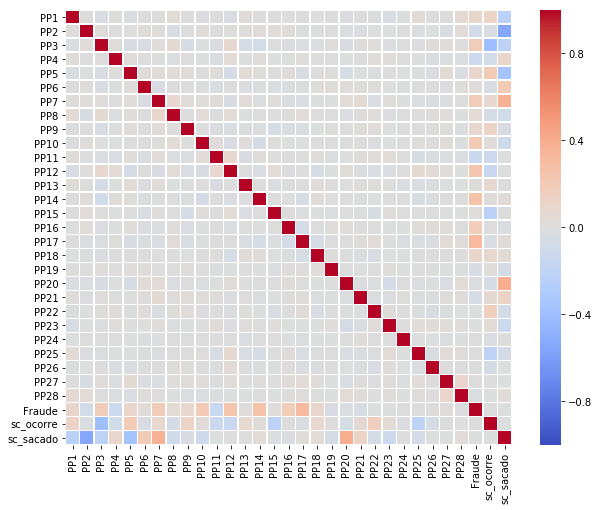

In [67]:
# plotting correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), vmin=-1, cmap='coolwarm', linewidths=.5)
plt.show()

De acordo com o heatmap, a correlação entre as colunas é bem fraca. No entanto, podemos analisar quais colunas tem maior correlação entre si conforme abaixo

In [68]:
df_corr = df.corr().abs().unstack().sort_values(kind='quicksort')

In [69]:
df_corr = df_corr[(df_corr > 0.1) & (df_corr < 1)]

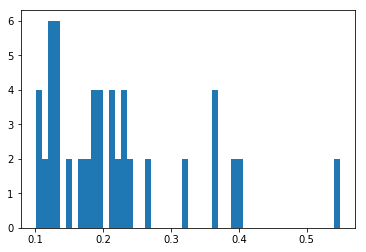

In [70]:
df_corr.hist(bins=50, grid=False)
plt.show()

In [71]:
df_corr_col = df_corr[df_corr > 0.4].index.unique(level=0).tolist()

In [72]:
df_corr_col

['sc_ocorre', 'PP3', 'PP2', 'sc_sacado']

As colunas que tem maiores correlações entre si são: `sc_ocorre` (ocorrência padronizada), `PP3`, `PP2` e `sc_sacado` (sacado padronizado).

Podemos observar abaixo as distriuições dessas colunas em pares e sinalizada pela target `Fraude`

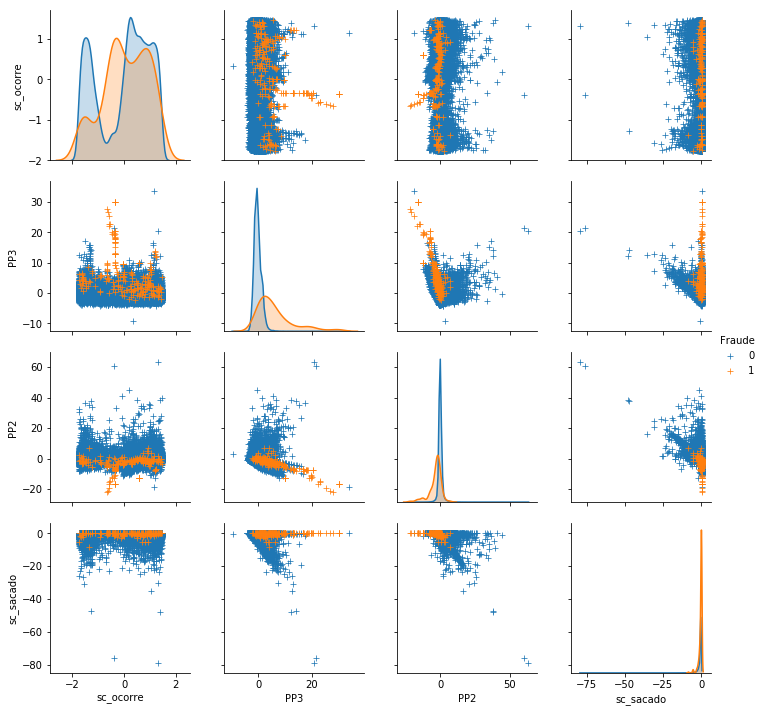

In [73]:
sns.pairplot(df, vars=df_corr_col, hue='Fraude', markers='+')
plt.show()

Abaixo temos a distribuições de cada colunas para cada valor da target

<Figure size 432x288 with 0 Axes>

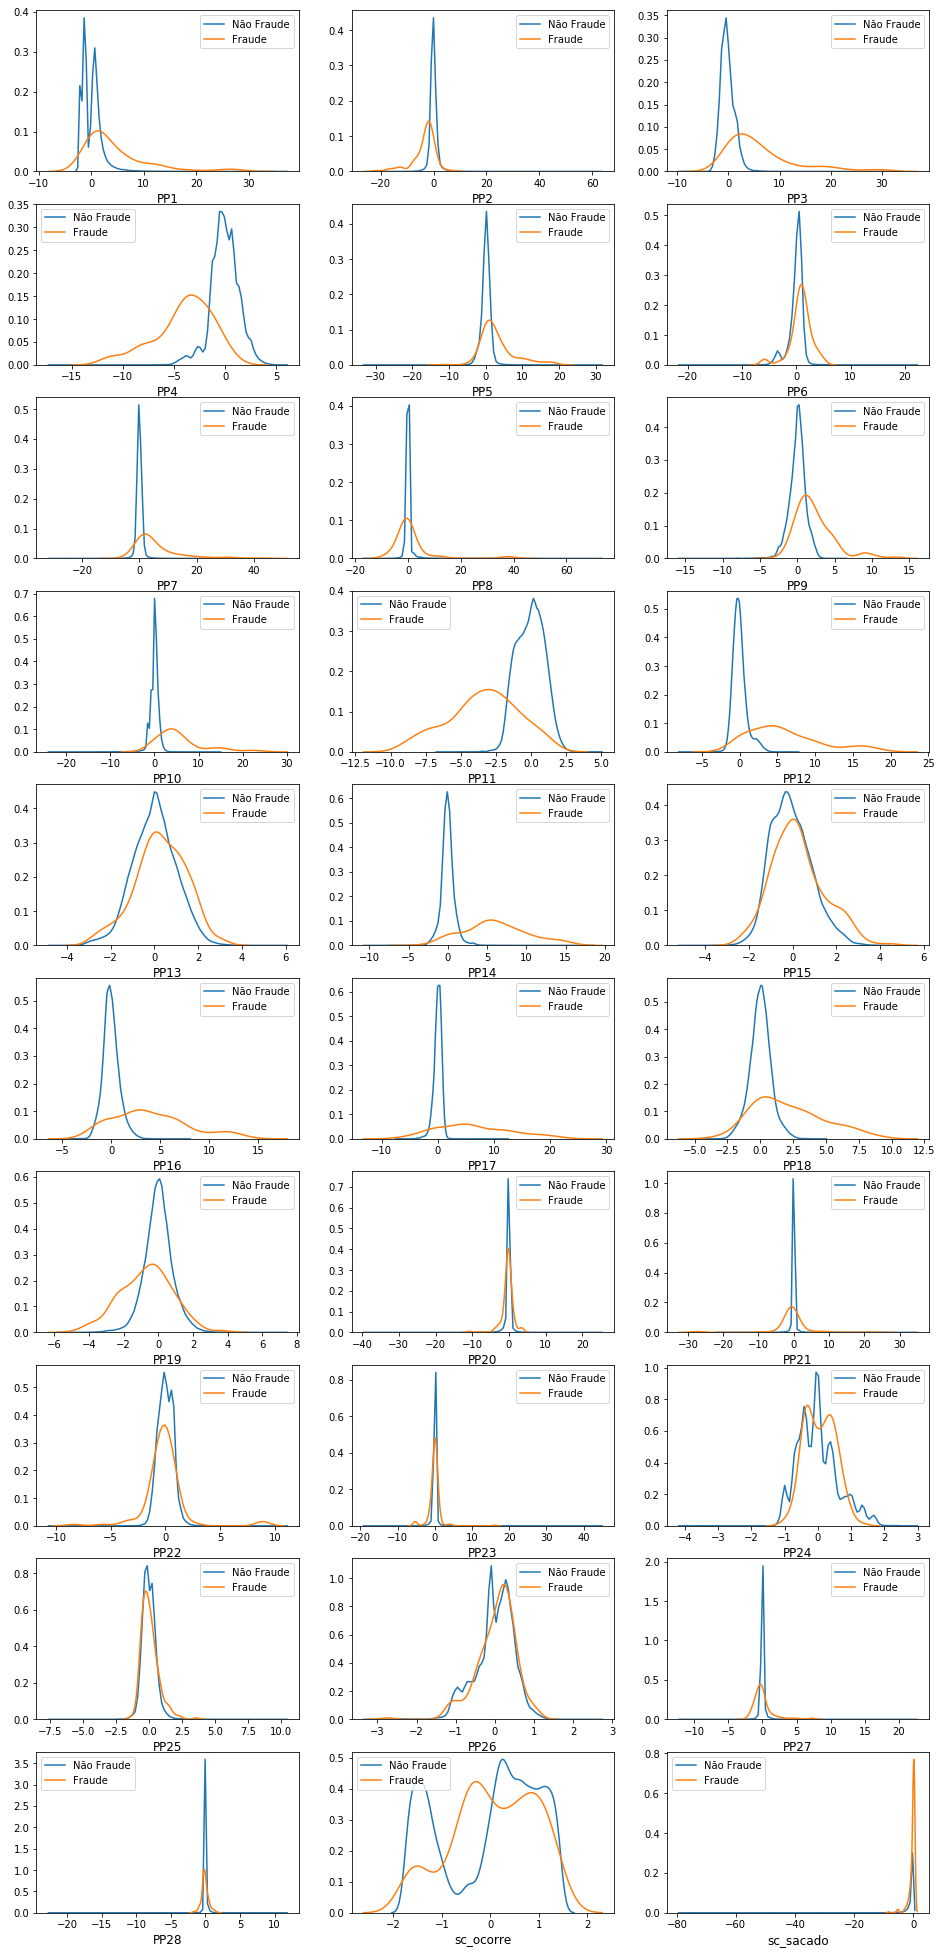

In [74]:
# plota distribuições de cada coluna para cada valor da target

def plot_distributions(df):
    df_col = df.columns.tolist()
    df_col.remove('Fraude')
    
    i = 0
    df_nao_fraude = df.query('Fraude == 0')
    df_fraude = df.query('Fraude == 1')

    plt.figure()
    fig, ax = plt.subplots(10, 3, figsize=(16, 35))

    for feature in df_col:
        i += 1
        plt.subplot(10, 3, i)
        sns.kdeplot(df_nao_fraude[feature],label="Não Fraude")
        sns.kdeplot(df_fraude[feature], label="Fraude")
        plt.xlabel(feature, fontsize=12)
    plt.show()
    
plot_distributions(df)    

Podemos observar que enquanto algumas colunas tem distribuições similares para casos de `Fraude` e `Não Fraude`, tais como `PP20`, `PP25` e `PP28`, outras apresentam maior diferença de cada distribuição (`P10`, `P11` e `P14`), podendo nos ajudar a discriminar a target

### Dataprep
Agora que sabemos que a target é desbalanceada, irei preparar os dados para treinamento sem considerar o desbalanceamento, que será treinado com um `XGBoost`, e considerando o desbalanceamento, realizando `Random Under Sample`.

Não optei por balancear os dados com técnicas de over sampling como `SMOTE`, pois poderia criar dados fictícios que não pudessem condizer com situações reais dos dados. Dessa forma, preferi balancear os dados diminuindo a classe majoritária de fraudes utilizando `Random Under Sample`

In [445]:
# recebe um dataset e retorna os dados de treino, teste e treino com random under sampling

def df_split(df):
    x = df.drop('Fraude', axis=1)
    y = df['Fraude']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, stratify=y, random_state=42)
    x_train_res, y_train_res = rus.fit_sample(x_train, y_train)
                          
    return x, y, x_train, x_test, y_train, y_test, x_train_res, y_train_res

In [446]:
x, y, x_train, x_test, y_train, y_test, x_train_res, y_train_res = df_split(df)

### Dataviz
Antes de treinar os modelos, irei visualizar os dados utilizando `TSNE`, `PCA` e `UMAP` para avaliar se esses algoritmos conseguem ajudar a discriminar os casos de fraudes, além de nos ajudar na visualização da distribuição dos dados

In [429]:
# aplica redução de dimensionalidade utilizando TSNE, PCA e UMAP
def dim_red(x):
    print('<------ TSNE ------>')
    t0 = time()
    x_dim_tsne = TSNE(n_components=2, random_state=42).fit_transform(x.values)
    print(f'Took {round(time()-t0)} secs to fit') 
    
    print('<------ PCA ------>')
    t0 = time()
    x_dim_pca = PCA(n_components=2, random_state=42).fit_transform(x.values)
    print(f'Took {round(time()-t0)} secs to fit') 
    
    print('<------ UMAP ------>')
    t0 = time()
    x_dim_umap = UMAP(n_components=2, random_state=42).fit_transform(x.values)
    print(f'Took {round(time()-t0)} secs to fit') 

    return x_dim_tsne, x_dim_pca, x_dim_umap

# plota scatter plot de cada dataset com dimensão reduzida para TSNE, PCA e UMAP
def plot_dim_red(x_dim_tsne, x_dim_pca, x_dim_umap, y):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
    f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

    blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
    red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

    # t-SNE scatter plot
    ax1.scatter(x_dim_tsne[:,0], x_dim_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', marker='.', alpha=0.001)
    ax1.scatter(x_dim_tsne[:,0], x_dim_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', marker='+', alpha=0.5)
    ax1.set_title('t-SNE', fontsize=14)

    ax1.legend(handles=[blue_patch, red_patch])


    # PCA scatter plot
    ax2.scatter(x_dim_pca[:,0], x_dim_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', marker='.', alpha=0.001)
    ax2.scatter(x_dim_pca[:,0], x_dim_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', marker='+', alpha=0.5)
    ax2.set_title('PCA', fontsize=14)

    ax2.legend(handles=[blue_patch, red_patch])


    # UMAP scatter plot
    ax3.scatter(x_dim_pca[:,0], x_dim_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', marker='.', alpha=0.001)
    ax3.scatter(x_dim_pca[:,0], x_dim_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', marker='+', alpha=0.5)
    ax3.set_title('UMAP', fontsize=14)

    ax3.legend(handles=[blue_patch, red_patch])

    plt.show()

Realizando a redução de dimensão com o dataset inteiro, dificilmente podemos observar casos de fraude, visto que os casos são bem inferiores aos de não fraude

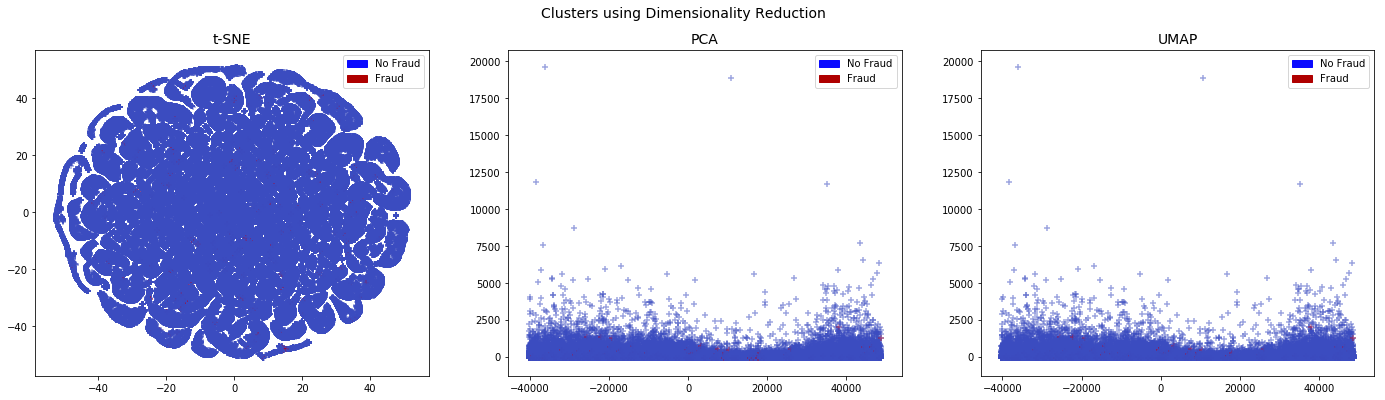

In [94]:
x_dim_tsne, x_dim_pca, x_dim_umap = dim_red(x_train)
plot_dim_red(x_dim_tsne, x_dim_pca, x_dim_umap, y_train)

Realizando a redução de dimesionalidade com o dataset reduzido (balanceado), podemos observar que os algoritmos conseguem discriminar melhor cada target

<------ TSNE ------>
Took 3 secs to fit
<------ PCA ------>
Took 0 secs to fit
<------ UMAP ------>
Took 1 secs to fit


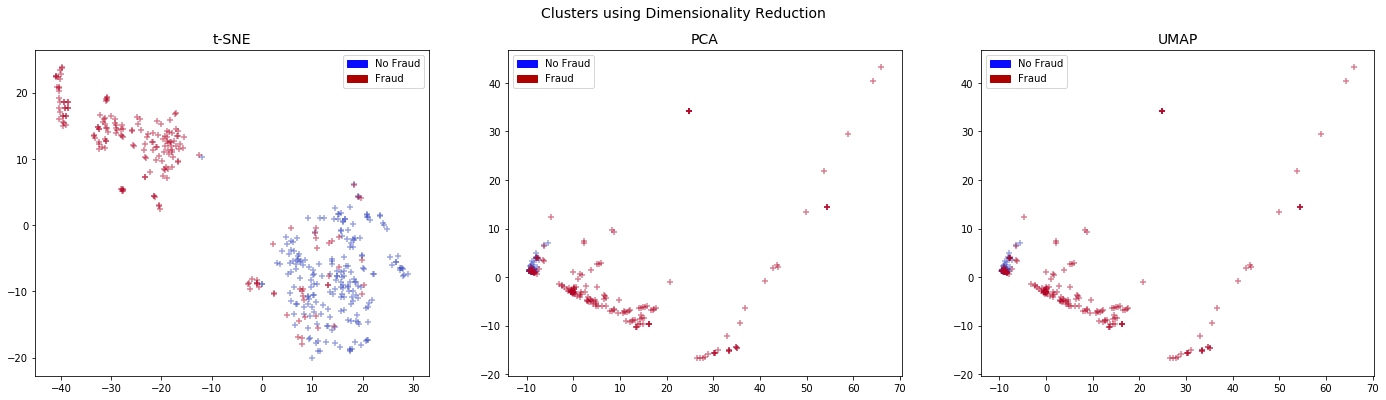

In [448]:
x_dim_tsne_res, x_dim_pca_res, x_dim_umap_res = dim_red(x_train_res)
plot_dim_red(x_dim_tsne_res, x_dim_pca_res, x_dim_umap_res, y_train_res)

### Modelling
Para a modelagem, utilizarei os algoritmos `Logistic Regression`, `KNN`, `Decision Tree`, `Random Forest`, `AdaBoost`, `SVM` e `Multi layer perpeptron` nos dados balanceados; e `XGBoost` no dataset original, visto que o `XGBoost` tem o hiperparâmetro `scale_pos_weight` que leva em consideração o desbalanceamento dos dados.

Para cada modelo, realizarei cross validation com 10 pastas e obterei a `ROC AUC`, `RECALL` e `ACURÁCIA` dos dados de treino e teste para análise posterior

In [449]:
classifiers = {'Logistic Regression' : LogisticRegression(),
               'KNN': KNeighborsClassifier(),
               'Decision Tree': DecisionTreeClassifier(),
               'Random Forest': RandomForestClassifier(),
               'AdaBoost': AdaBoostClassifier(),
               'SVM': SVC(),
               'Multi layer perpeptron': MLPClassifier()}

In [461]:
# definindo função para treinar os classificadores e retornar os resultados dos modelos

def train_clfs(classifiers, x_train, x_test, y_train, y_test):
    
    names = []
    results_train_cv_roc_auc = []
    results_train_cv_recall = []
    results_train_cv_accuracy = []
    results_test_roc_auc = []
    results_test_recall = []
    results_test_accuracy = []
        
    for name, clf in classifiers.items():
        print(f'Classifier: {name}\n')        
        cv_auc = cross_val_score(clf, x_train, y_train, cv=10, scoring='roc_auc', ) 
        cv_rec = cross_val_score(clf, x_train, y_train, cv=10, scoring='recall')                                
        cv_acc = cross_val_score(clf, x_train, y_train, cv=10, scoring='accuracy')        
        
        clf.fit(x_train, y_train)        
        y_pred = clf.predict(x_test)
        
        names.append(name)
        results_train_cv_roc_auc.append(cv_auc)
        results_train_cv_recall.append(cv_rec)
        results_train_cv_accuracy.append(cv_acc)
        results_test_roc_auc.append(roc_auc_score(y_test, y_pred))
        results_test_recall.append(recall_score(y_test, y_pred))
        results_test_accuracy.append(accuracy_score(y_test, y_pred))

        print(f'CV\t-\troc_auc:\t{round(cv_auc.mean(), 3)}')
        print(f'CV\t-\trecall:\t\t{round(cv_rec.mean(), 3)}')
        print(f'CV\t-\taccuracy:\t{round(cv_acc.mean(), 3)}')

        print(f'Test\t-\troc_auc:\t{round(roc_auc_score(y_test, y_pred), 3)}')         
        print(f'Test\t-\trecall:\t\t{round(recall_score(y_test, y_pred), 3)}')          
        print(f'Test\t-\taccuracy:\t{round(accuracy_score(y_test, y_pred), 3)}')      
        print('\n<-------------------------->\n')

    df_results_test = pd.DataFrame(index=names, columns=['ROC_AUC', 'RECALL', 'ACCURACY'])
    df_results_test['ROC_AUC'] = results_test_roc_auc
    df_results_test['RECALL'] = results_test_recall
    df_results_test['ACCURACY'] = results_test_accuracy

    return names, results_train_cv_roc_auc, results_train_cv_recall, results_train_cv_accuracy, df_results_test

Para cada classificador, podemos checar as métricas conforme abaixo

In [462]:
names, results_train_cv_roc_auc, results_train_cv_recall, results_train_cv_accuracy, df_results_test = train_clfs(classifiers, x_train_res, x_test, y_train_res, y_test)

Classifier: Logistic Regression

CV	-	roc_auc:	0.979
CV	-	recall:		0.895
CV	-	accuracy:	0.92
Test	-	roc_auc:	0.919
Test	-	recall:		0.889
Test	-	accuracy:	0.949

<-------------------------->

Classifier: KNN

CV	-	roc_auc:	0.964
CV	-	recall:		0.845
CV	-	accuracy:	0.91
Test	-	roc_auc:	0.919
Test	-	recall:		0.861
Test	-	accuracy:	0.977

<-------------------------->

Classifier: Decision Tree

CV	-	roc_auc:	0.876
CV	-	recall:		0.865
CV	-	accuracy:	0.883
Test	-	roc_auc:	0.874
Test	-	recall:		0.889
Test	-	accuracy:	0.858

<-------------------------->

Classifier: Random Forest

CV	-	roc_auc:	0.97
CV	-	recall:		0.865
CV	-	accuracy:	0.908
Test	-	roc_auc:	0.915
Test	-	recall:		0.861
Test	-	accuracy:	0.969

<-------------------------->

Classifier: AdaBoost

CV	-	roc_auc:	0.962
CV	-	recall:		0.87
CV	-	accuracy:	0.9
Test	-	roc_auc:	0.894
Test	-	recall:		0.861
Test	-	accuracy:	0.927

<-------------------------->

Classifier: SVM

CV	-	roc_auc:	0.977
CV	-	recall:		0.83
CV	-	accuracy:	0.91
Test	-	ro

C:\Users\milto\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\milto\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\milto\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\milto\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

CV	-	roc_auc:	0.974
CV	-	recall:		0.9
CV	-	accuracy:	0.918
Test	-	roc_auc:	0.916
Test	-	recall:		0.861
Test	-	accuracy:	0.97

<-------------------------->



C:\Users\milto\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Agora treinarei o `XGBoost` com cross validation com 5 pastas e utilizando `Random Search` para tunar alguns hiperparâmetros

In [96]:
clf_xgb = xgb.XGBClassifier()

scale_pos_weight = len(df.query('Fraude == 0')) / len(df.query('Fraude == 1'))

param_grid = {'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
              'learning_rate': [0.01, 0.10, 0.1, 0.2, 0.3],              
              'colsample_bytree': [0.3, 0.5, 0.7],
              'min_child_weight': [0.01, 0.1, 0.5],
              'gamma': [0, 0.2, 0.5],
              'reg_lambda': [0.1, 1.0, 5.0, 10.0],
              'n_estimators': [100],
              'scale_pos_weight': [scale_pos_weight]}

rs_clf = RandomizedSearchCV(clf_xgb, param_grid, n_iter=50,
                            n_jobs=-1, verbose=2, cv=5,                            
                            scoring='recall', random_state=42)

rs_clf.fit(x_train, y_train)

Os melhores hiperparâmetros são:

In [198]:
rs_clf.best_params_

{'scale_pos_weight': 631.9113924050633,
 'reg_lambda': 1.0,
 'n_estimators': 100,
 'min_child_weight': 0.5,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0.5,
 'colsample_bytree': 0.3}

Por fim, irei incluir a `ROC AUC`, `RECALL` e `ACURÁCIA` do `XGBoost` com as métricas dos demais classificadores para poder compará-los

In [464]:
clf_xgb_best = rs_clf

y_pred = clf_xgb_best.predict(x_test)

df_results_xgb = pd.DataFrame(index=['XGBoost'], columns=['ROC_AUC', 'RECALL', 'ACCURACY'])

df_results_xgb['ROC_AUC'] = roc_auc_score(y_test, y_pred)
df_results_xgb['RECALL'] = recall_score(y_test, y_pred)
df_results_xgb['ACCURACY'] = accuracy_score(y_test, y_pred)

df_results = pd.concat([df_results_test, df_results_xgb])

In [469]:
df_results

,ROC_AUC,RECALL,ACCURACY
Logistic Regression,0.919115,0.888889,0.949244
KNN,0.919293,0.861111,0.977289
Decision Tree,0.873509,0.888889,0.858178
Random Forest,0.915153,0.861111,0.969022
AdaBoost,0.893897,0.861111,0.926578
SVM,0.909433,0.833333,0.985289
Multi layer perpeptron,0.915710,0.861111,0.970133
XGBoost,0.887175,0.777778,0.996222


### Conclusion

Por ser um caso de detecção de fraude, a métrica ideal, ao meu ver, seria o `RECALL`, visto que deixar de prever uma fraude quando o caso for uma fraude de fato é mais prejudicial que prever uma fraude quando o caso não for

Deixar de prever uma fraude pode gerar maiores prejuízos financeiros, além de manchar a reputação da empresa

Abaixo podemos ver os resultados do cross validation do treino para cada classificador

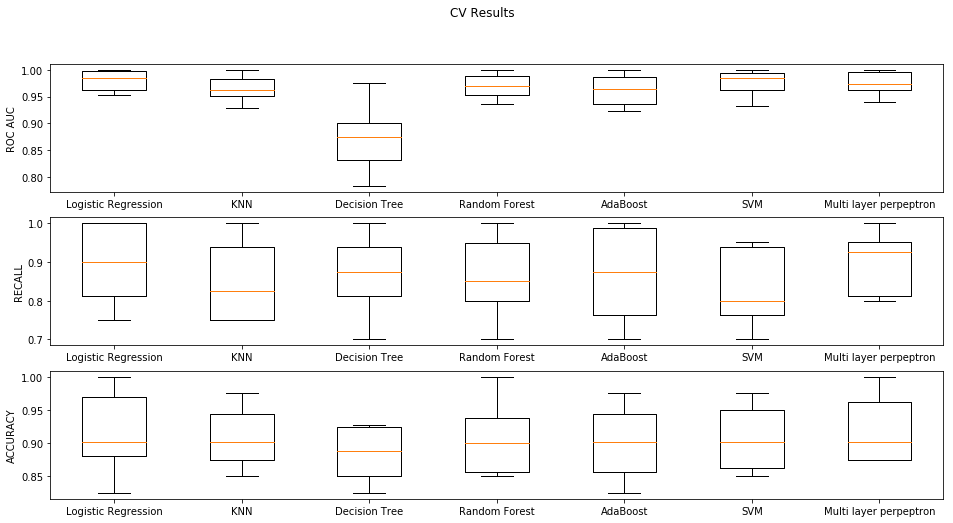

In [467]:
def plot_cv(names, roc_auc, recall, accuracy):
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,8))
    f.suptitle('CV Results')

    ax1.boxplot(roc_auc)
    ax1.set_ylabel('ROC AUC')    
    ax1.set_xticklabels(names)
    
    ax2.boxplot(recall)
    ax2.set_ylabel('RECALL')    
    ax2.set_xticklabels(names)
    
    ax3.boxplot(accuracy)
    ax3.set_ylabel('ACCURACY')    
    ax3.set_xticklabels(names)
    
    plt.show()
    
plot_cv(names, results_train_cv_roc_auc, results_train_cv_recall, results_train_cv_accuracy)    

Com exceção da `Decision Tree`, todos os classificadores tiveram altos valores de `ROC AUC` e valores similares de `RECALL` e `ACURÁCIA`

Abaixo podemos ver as métricas no teste:

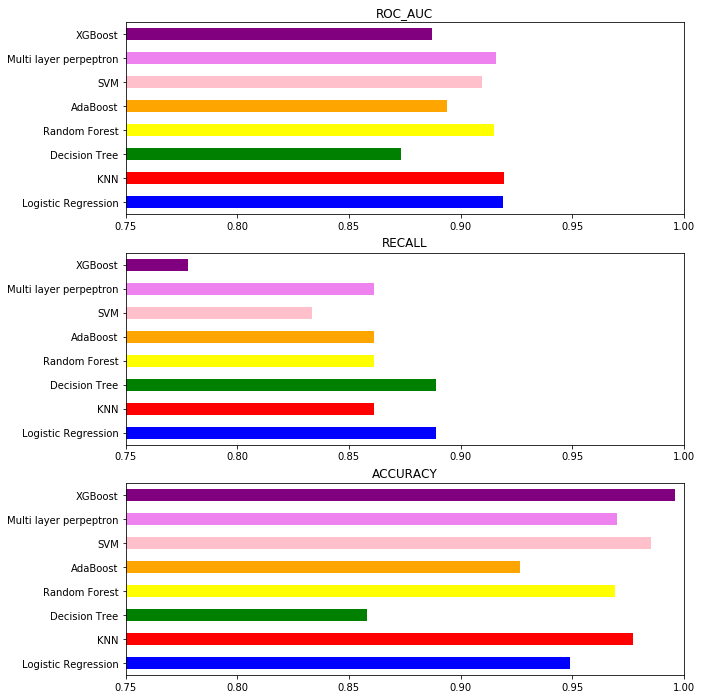

In [471]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,12))

color = ['blue', 'red', 'green', 'yellow', 'orange', 'pink', 'violet', 'purple']

df_results['ROC_AUC'].plot(kind='barh', ax=ax1, xlim=(0.75, 1), title='ROC_AUC', color=color)
df_results['RECALL'].plot(kind='barh', ax=ax2, xlim=(0.75, 1), title='RECALL', color=color)
df_results['ACCURACY'].plot(kind='barh', ax=ax3, xlim=(0.75, 1), title='ACCURACY', color=color)
plt.show()

Podemos observar que apesar de tunar os hiperparâmetros do `XGBoost` e tentar maximizar o `RECALL`, este foi o modelo que obteve o pior resultado, embora foi o que obteve maior `Acurácia`.

Em termos de `RECALL`, a `Logistic Regression` e `Decistion Tree` foram os modelos que obtiveram os melhores resultados. Já em termos de `ROC AUC`, o `KNN`, `Logistic Regression` e `Multi layer perceptron` foram os melhores.

Para obter o maior `RECALL` de cada modelo, podemos utilizar a probabilidade `predict_proba` de cada classificador e avaliar qual limiar `threshold` consideraremos o valor como fraude. Dessa forma podemos avaliar o quanto de risco que estamos dispostos a tomar para o negócio

In [472]:
# Create a confusion matrix
def plot_confusion_matrix(y_test, y_pred, title='Confusion matrix'):
    
    cm = confusion_matrix(y_test, y_pred)
    classes = ['Não Fraude', 'Fraude']

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, )
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# cria matrix de confusão para cada threshold
def train_clf_threshold(clf,  x_train, x_test, y_train, y_test):
    thresholds = np.arange(0.1, 1, 0.1)
    
    clf.fit(x_train, y_train)
    y_proba = clf.predict_proba(x_test)
    
    plt.figure(figsize=(10,10))

    j = 1
    for i in thresholds:
        y_test_predictions_high_recall = y_proba[:,1] > i

        plt.subplot(4, 3, j)
        j += 1

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_test,y_test_predictions_high_recall)
        np.set_printoptions(precision=2)

        print(f"Threshold: {round(i, 1)} - Recall in the testing dataset: ", round(recall_score(y_test, y_test_predictions_high_recall), 2))

        # Plot non-normalized confusion matrix
        plot_confusion_matrix(y_test, y_test_predictions_high_recall, title=f'Threshold >= {round(i, 1)}')

No caso, para a `Logistic Regression`, um `threshold >= 0.4` oferece um `RECALL` de `0.92`

Threshold: 0.1 - Recall in the testing dataset:  0.92
Threshold: 0.2 - Recall in the testing dataset:  0.92
Threshold: 0.3 - Recall in the testing dataset:  0.92
Threshold: 0.4 - Recall in the testing dataset:  0.92
Threshold: 0.5 - Recall in the testing dataset:  0.89
Threshold: 0.6 - Recall in the testing dataset:  0.86
Threshold: 0.7 - Recall in the testing dataset:  0.86
Threshold: 0.8 - Recall in the testing dataset:  0.86
Threshold: 0.9 - Recall in the testing dataset:  0.86


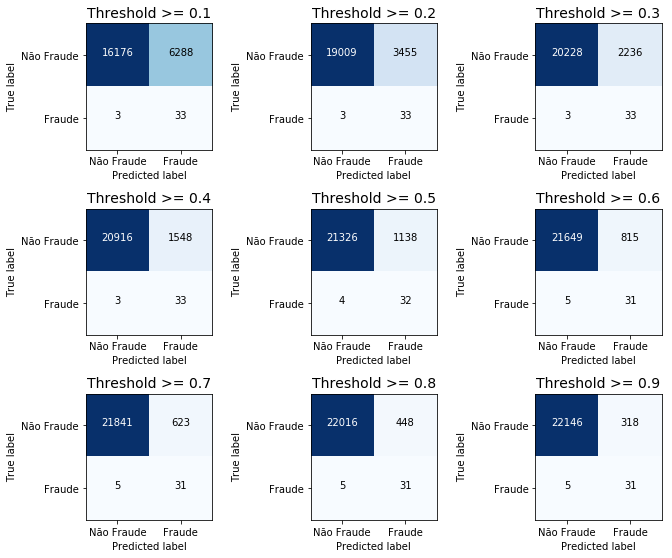

In [474]:
train_clf_threshold(LogisticRegression(), x_train_res, x_test, y_train_res, y_test)

Já para `Adaboost`, esse mesmo `threshold >= 0.4` oferece um `RECALL = 1`, no entanto, estamos considerando `222270` casos como fraude quando na verdade não são

Threshold: 0.1 - Recall in the testing dataset:  1.0
Threshold: 0.2 - Recall in the testing dataset:  1.0
Threshold: 0.3 - Recall in the testing dataset:  1.0
Threshold: 0.4 - Recall in the testing dataset:  1.0
Threshold: 0.5 - Recall in the testing dataset:  0.86
Threshold: 0.6 - Recall in the testing dataset:  0.06
Threshold: 0.7 - Recall in the testing dataset:  0.0
Threshold: 0.8 - Recall in the testing dataset:  0.0
Threshold: 0.9 - Recall in the testing dataset:  0.0


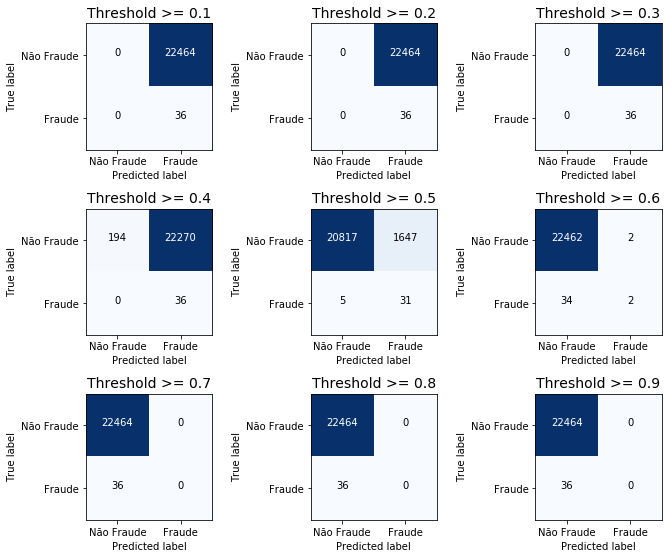

In [477]:
train_clf_threshold(AdaBoostClassifier(), x_train_res, x_test, y_train_res, y_test)

E para maioria dos thrsholds do `XGBoost`, o modelo prevê que os casos são fraude, ainda que não sejam

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   13.4s finished


Threshold: 0.1 - Recall in the testing dataset:  1.0
Threshold: 0.2 - Recall in the testing dataset:  1.0
Threshold: 0.3 - Recall in the testing dataset:  1.0
Threshold: 0.4 - Recall in the testing dataset:  1.0
Threshold: 0.5 - Recall in the testing dataset:  1.0
Threshold: 0.6 - Recall in the testing dataset:  0.97
Threshold: 0.7 - Recall in the testing dataset:  0.92
Threshold: 0.8 - Recall in the testing dataset:  0.92
Threshold: 0.9 - Recall in the testing dataset:  0.0


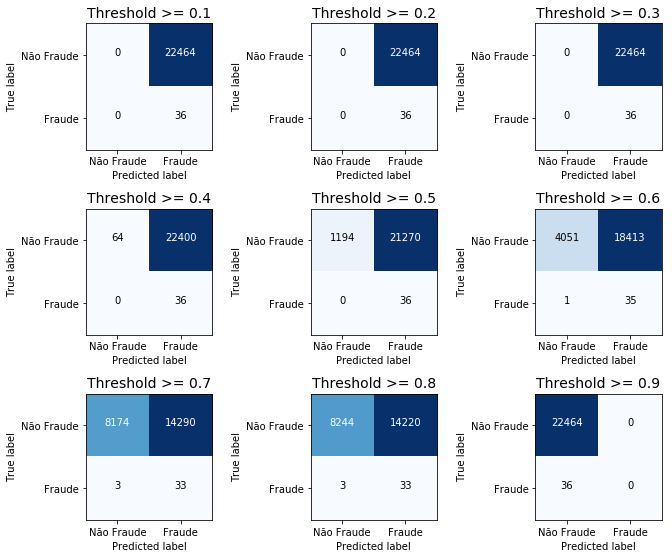

In [480]:
train_clf_threshold(clf_xgb_best, x_train_res, x_test, y_train_res, y_test)

Dessa forma, dependendo dos custos de erro de previsão de cada caso, podemos escolher a melhor combinação de classificador com  threshold para otimizar a minimização de custos de cada caso e maximize o ganho de cada acerto

Por fim, se tivéssemos mais informações das colunas, poderíamos criar novas features que pudesse melhor a discriminação do modelo, além de obter maiores casos de casos de fraudes para aumentarmos os dados de treino